In [3]:
# Importing the relevant libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

#Librarries specific to the algorithms
from sklearn.ensemble import RandomForestRegressor
from pyswarm import pso

In [27]:
# Import the dataset. Please ensure the excel sheet is in the same folder as the notebok and change the sheetname depending on the data you wish to train on. The excel sheet has 4 tabs in total, correpsonding to the active learning cycles 
data = pd.read_excel('Data for model.xlsx', sheet_name ='Seed')


In [28]:
#Preliminary overview of the dataset
data.head()

,CT,CR,AT,AR,Ratio,Pore
0,200,1.0,300,1.0,2.0,0.002902
1,200,4.0,700,2.0,0.5,0.112226
2,300,3.0,500,0.5,3.0,0.096670
3,500,2.0,800,3.0,2.0,0.183339
4,500,0.5,400,4.0,1.0,0.006232


In [29]:
len(data)

10

In [30]:
#Assigning the input variables and target variable (X= inputm y=target)
X = data.drop(labels= ['Pore'], axis=1)
y = data['Pore']


(array([2., 0., 0., 0., 2., 1., 1., 1., 0., 3.]),
 array([0.0029017 , 0.02294113, 0.04298056, 0.06301999, 0.08305942,
        0.10309885, 0.12313828, 0.14317771, 0.16321714, 0.18325657,
        0.203296  ]),
 <BarContainer object of 10 artists>)

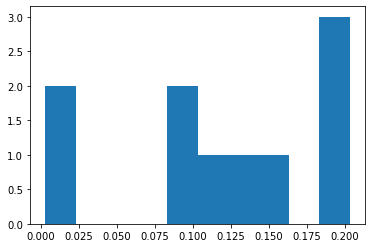

In [31]:
# Descriptive statistics for of target variable
y.describe()

import matplotlib.pyplot
matplotlib.pyplot.hist(y)

In [32]:
#overview of the input variables as a dataframe
X

,CT,CR,AT,AR,Ratio
0,200,1.0,300,1.0,2.0
1,200,4.0,700,2.0,0.5
2,300,3.0,500,0.5,3.0
3,500,2.0,800,3.0,2.0
4,500,0.5,400,4.0,1.0
5,600,2.0,300,2.0,0.5
6,750,1.5,600,0.5,2.0
7,800,3.0,800,1.0,3.0
8,800,0.5,400,3.0,1.0
9,850,1.0,300,1.0,1.5


The training R2 is:  0.8538750378141051
MSE: 0.00
RMSE of test set: 0.026


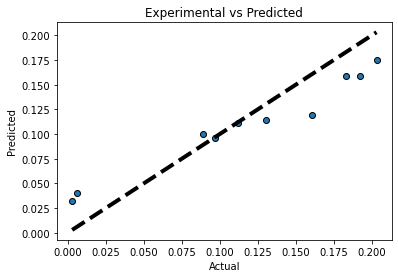

In [33]:
# Fitting RandomForest (RF) Regression to the dataset. Since this is a rather small dataset, we do not split it into training:test. 
#Rather we use the entire data for training the RF model, which is the forward model in this study.


from sklearn.ensemble import RandomForestRegressor
modelRF =  RandomForestRegressor(n_estimators = 100,  max_features='sqrt', max_depth = None, min_samples_split=2)
modelRF.fit(X, y)

#Measure the R2 for training and test set
model_score = modelRF.score(X,y)
print("The training R2 is: ", modelRF.score(X, y))


from sklearn.metrics import mean_squared_error
from math import sqrt


y_pred = modelRF.predict(X)

# The mean squared error & Variance
print("MSE: %.2f"% mean_squared_error(y, y_pred))
print("RMSE of test set: %.3f"% sqrt(mean_squared_error(y, y_pred)))


#Plot the actual v/s predicted
fig, ax = plt.subplots()
ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Experimental vs Predicted")
plt.show()


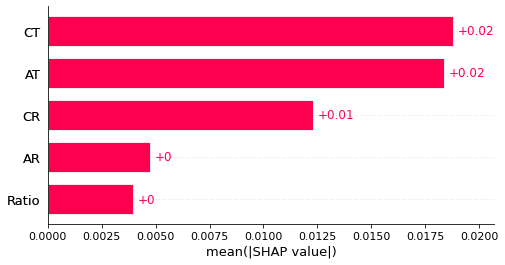

In [34]:
#Perform feature importance via SHAP analysis by using the RF model
import shap

explainer1 = shap.Explainer(modelRF)
shap_values1 = explainer1(X)

shap.plots.bar(shap_values1, max_display=15)

# Particle Swarm Optimization

In [35]:
#Develop the PSO which uses RF as surrogate model and inturn recommends optimal values of the input necessray to maximize our target variable.

def black_box_function(x):
    Ctemp, Ctime, Acttemp, Acttime, Ratio = x
    df = pd.DataFrame({"CT": [Ctemp], "CR": [Ctime], "AT": [Acttemp], "AR": [Acttime], "Ratio": [Ratio]})
    y_PSO = -1*modelRF.predict(df) #PSO by default is a minimizing optimizer. The surrogate model (RF) is multiplied by -1 to inverse the condition and devise a maximizing objective function which is the goal of this project
    return y_PSO

# Initialize lists to store optimal input values and target variable

optimal_inputs = []
target_variable = []
#function_values = []

#Define the lower and upper bounds of the input variables. They must be placed in the order of the appearance in the above dataframe

lb = [200, 0.5, 300, 0.5, 0.5]
ub = [700, 4, 800, 4, 3]


# Run multiple rounds of optimization to get a decent sense of the values. Swarmsize and maxiter are the two tuning parameter used. 
#Generally for a small dataset as this with 5 input variables, swarmsize between 20-100 and maxiter between 20-50 shoudl suffice.
#However these values are user dependent and can be defined based on the scope of project, computation capacity and user experience

for _ in range(3): # the loop range can be increased or decreased depeninding on need. In the actual paper we used 10 loops, whihc would generate us 10 experimental conditions worth investigation. we would then collectively decide what experiments to perform based on our domain knowledge and experimental constraints.
    xopt, fopt = pso(black_box_function, lb, ub,swarmsize=50, maxiter=50)
    print("Optimal input variables:", xopt)
    print("Optimal function value:", fopt)
    
    # Round optimal input values and function value to two decimal places
    xopt_rounded = np.round(xopt, 2)
    fopt_rounded = -1*np.round(fopt, 4)# multiplied by -1 to get positive values of taregt variable in the final step
    
 # Store optimal input values and function values
    optimal_inputs.append( xopt_rounded)
    target_variable.append(fopt_rounded)

Stopping search: maximum iterations reached --> 50
Optimal input variables: [7.00000000e+02 2.10931932e+00 8.00000000e+02 5.74038253e-01
 2.51176129e+00]
Optimal function value: [-0.17853097]
Stopping search: maximum iterations reached --> 50
Optimal input variables: [700.           2.16291448 800.           3.40683643   2.73498147]
Optimal function value: [-0.17645471]
Stopping search: maximum iterations reached --> 50
Optimal input variables: [6.98708026e+02 2.07145567e+00 8.00000000e+02 5.00000000e-01
 2.82768927e+00]
Optimal function value: [-0.17853097]


In [36]:
# Create a dataframe to store the results
results_df = pd.DataFrame(optimal_inputs, columns=["Optimal_Ctemp", "Optimal_Ctime", "Optimal_Acttemp", "Optimal_Acttime", "Optimal_Ratio"])
results_df["Micropore"] = target_variable  
results_df

,Optimal_Ctemp,Optimal_Ctime,Optimal_Acttemp,Optimal_Acttime,Optimal_Ratio,Micropore
0,700.00,2.11,800.0,0.57,2.51,[0.1785]
1,700.00,2.16,800.0,3.41,2.73,[0.1765]
2,698.71,2.07,800.0,0.50,2.83,[0.1785]
